## Oil Price Forecasting with ARIMA vs Naïve

In [1]:
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import random
import warnings
import statsmodels.api as sm

warnings.filterwarnings('ignore')

c:\Users\Samneh\Desktop\QuantDay1-14\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from kagglehub import KaggleDatasetAdapter

# Load the latest version
df = pd.read_csv("./datasets/commodity_prices.csv")

df.drop(columns=["Unnamed: 0"], inplace=True)

df.head()

,date,oil_brent,oil_dubai,coffee_arabica,coffee_robustas,tea_columbo,tea_kolkata,tea_mombasa,sugar_eu,sugar_us,sugar_world
0,1960-01-01,1.63,1.63,0.9409,0.696864,0.930301,1.121401,1.0374,0.122356,0.116845,0.0666
1,1960-02-01,1.63,1.63,0.9469,0.688707,0.930301,1.121401,1.0374,0.122356,0.119049,0.0679
2,1960-03-01,1.63,1.63,0.9281,0.688707,0.930301,1.121401,1.0374,0.122356,0.121254,0.0683
3,1960-04-01,1.63,1.63,0.9303,0.684519,0.930301,1.121401,1.0374,0.122356,0.123459,0.0681
4,1960-05-01,1.63,1.63,0.9200,0.690692,0.930301,1.121401,1.0374,0.122356,0.121254,0.0683


In [3]:
df_oil = df[['date', 'oil_dubai']]

df_oil['oil_dubai_returns'] = np.log(df_oil['oil_dubai']/df_oil['oil_dubai'].shift(1))

df_oil['oil_dubai_returns'] = df_oil['oil_dubai_returns'].fillna(0)

df_oil.head()

,date,oil_dubai,oil_dubai_returns
0,1960-01-01,1.63,0.0
1,1960-02-01,1.63,0.0
2,1960-03-01,1.63,0.0
3,1960-04-01,1.63,0.0
4,1960-05-01,1.63,0.0


In [4]:
adf_results =sm.tsa.stattools.adfuller(
    df_oil['oil_dubai_returns'],
    maxlag=20,
    regression='c',
    autolag='AIC',
    store=False,
    regresults=False
    )

for val in adf_results:
    print(val)



-22.01414997683107
0.0
0
755
{'1%': np.float64(-3.4390409569041207), '5%': np.float64(-2.865375732701395), '10%': np.float64(-2.568812543748081)}
-1422.2514708970612


In [5]:
# Convert date column to datetime
df_oil['date'] = pd.to_datetime(df_oil['date'])

# Resample by year and take the mean
df_oil = df_oil.set_index('date').resample('Y').mean().reset_index()

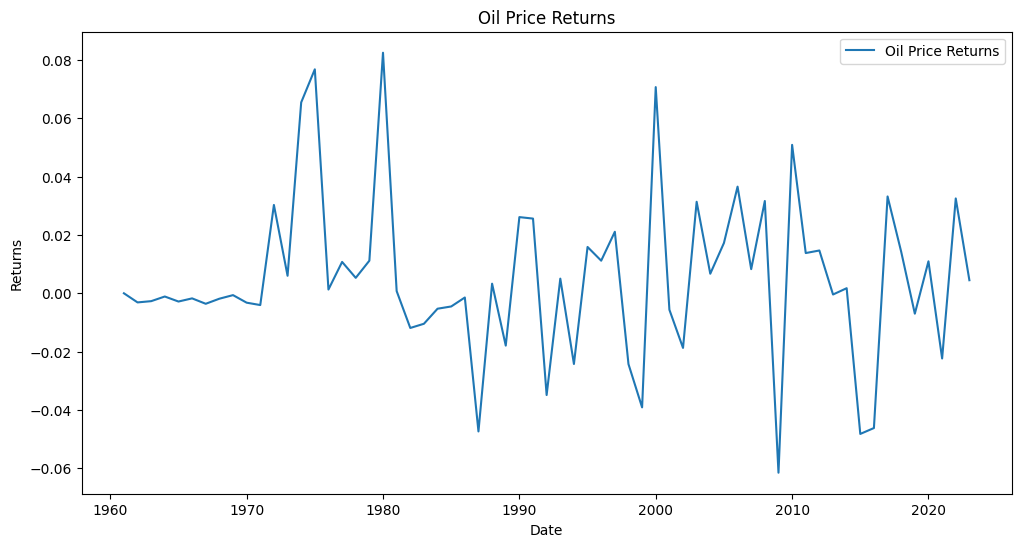

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(df_oil['date'], df_oil['oil_dubai_returns'], label='Oil Price Returns')
plt.title('Oil Price Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

In [7]:
def auto_arima_gridsearch(series, p_range=(0,5), d_range=(0,2), q_range=(0,5)):
    """
    Brute-force search for best ARIMA(p,d,q) based on AIC.
    series: pandas Series (time series data)
    p_range, d_range, q_range: tuples (min, max) for AR, I, MA orders
    """
    
    best_aic = np.inf
    best_order = None
    best_model = None
    
    for p in range(*p_range):
        for d in range(*d_range):
            for q in range(*q_range):
                try:
                    model = sm.tsa.ARIMA(series, order=(p,d,q))
                    results = model.fit()
                    if results.aic < best_aic:
                        best_aic = results.aic
                        best_order = (p,d,q)
                        best_model = results
                except:
                    continue
    return best_order, best_model


In [8]:
series = df_oil['oil_dubai_returns']  # your stationary series

# Let's do an 80/20 split
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

In [9]:
best_order, best_model = auto_arima_gridsearch(train, p_range=(0,10), d_range=(0,2), q_range=(0,10))

print("Best ARIMA order:", best_order)
print(best_model.summary())


Best ARIMA order: (0, 0, 0)
                               SARIMAX Results                                
Dep. Variable:      oil_dubai_returns   No. Observations:                   50
Model:                          ARIMA   Log Likelihood                 106.903
Date:                Sun, 31 Aug 2025   AIC                           -209.807
Time:                        17:48:41   BIC                           -205.983
Sample:                             0   HQIC                          -208.351
                                 - 50                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0064      0.004      1.485      0.137      -0.002       0.015
sigma2         0.0008      0.000      5.763      0.000       0.001       0.001
Ljung-Box (L1) (Q):     

In [10]:
forecast = best_model.get_forecast(steps=len(test))
arima_pred = forecast.predicted_mean
conf_int = forecast.conf_int()


In [11]:
naive_pred = np.repeat(train.iloc[-1], len(test))


In [12]:
from sklearn.metrics import mean_squared_error

rmse_arima = np.sqrt(mean_squared_error(test, arima_pred))
rmse_naive = np.sqrt(mean_squared_error(test, naive_pred))

print("RMSE ARIMA:", rmse_arima)
print("RMSE Naïve:", rmse_naive)

RMSE ARIMA: 0.025458435899781785
RMSE Naïve: 0.0564430864110208


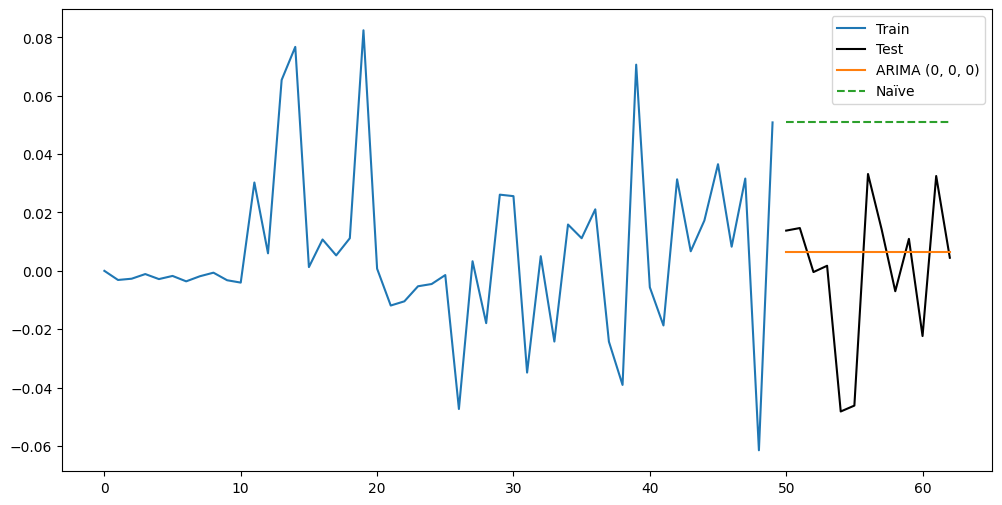

In [13]:
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test", color="black")
plt.plot(test.index, arima_pred, label=f"ARIMA {best_order}")
plt.plot(test.index, naive_pred, label="Naïve", linestyle="--")
plt.legend()
plt.show()

#### This shows that ARIMA failed to prove anything here, and that nothing is predictable.

#### Consistent with the finance theory, Past returns don’t reliably predict future returns. Markets look like random walks.

In [35]:
import yfinance as yf

stock = yf.download('AAPL', start='2020-01-01', end='2025-01-01', multi_level_index = False)

stock.head()

[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2020-01-02,72.538506,72.598884,71.292296,71.545882,135480400
2020-01-03,71.833305,72.594071,71.608700,71.765682,146322800
2020-01-06,72.405678,72.444321,70.703012,70.954188,118387200
2020-01-07,72.065147,72.671341,71.845369,72.415337,108872000
2020-01-08,73.224396,73.526287,71.768071,71.768071,132079200


In [36]:
stock['log_returns'] = np.log(stock['Close']/stock['Close'].shift(1))

df_stock = stock['log_returns']
# df_stock = stock['Close']
df_stock.dropna(inplace=True)
df_stock.head()


Date
2020-01-03   -0.009769
2020-01-06    0.007936
2020-01-07   -0.004714
2020-01-08    0.015958
2020-01-09    0.021019
Name: log_returns, dtype: float64

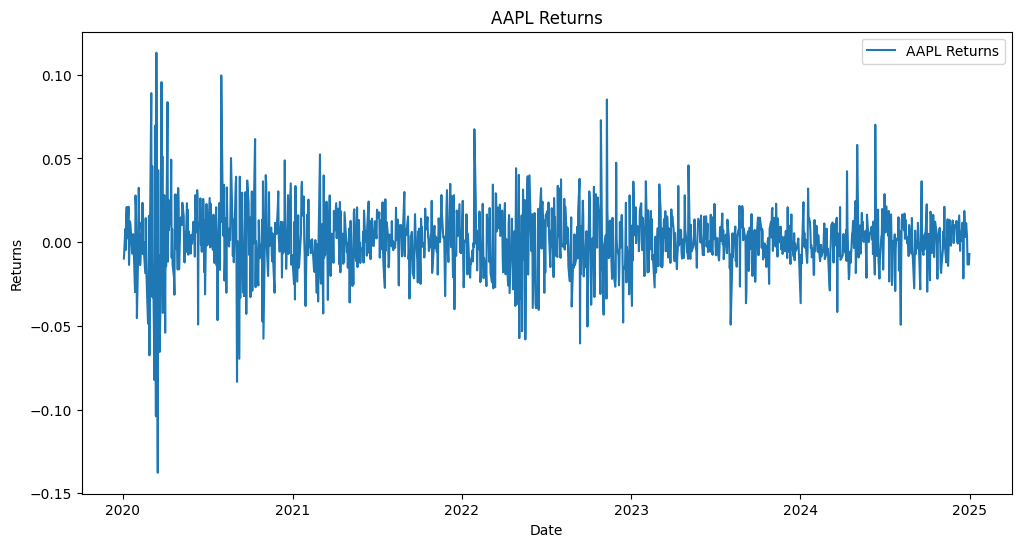

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(df_stock, label='AAPL Returns')
plt.title('AAPL Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

In [38]:
adf_results =sm.tsa.stattools.adfuller(
    df_stock,
    maxlag=20,
    regression='c',
    autolag='AIC',
    store=False,
    regresults=False
    )

for val in adf_results:
    print(val)


-11.284373924719482
1.430075272039661e-20
8
1248
{'1%': np.float64(-3.4356006420838963), '5%': np.float64(-2.8638586845641063), '10%': np.float64(-2.5680044958343604)}
-6198.211899641228


In [51]:
series_stock = df_stock  # your stationary series

# Let's do an 80/20 split
train_size = int(len(series_stock) * 0.8)
train, test = series_stock[:train_size], series_stock[train_size:]

best_order, best_model = auto_arima_gridsearch(train, p_range=(0,5), d_range=(0,1), q_range=(0,5))

print("Best ARIMA order:", best_order)
print(best_model.summary())


Best ARIMA order: (2, 0, 1)
                               SARIMAX Results                                
Dep. Variable:            log_returns   No. Observations:                 1005
Model:                 ARIMA(2, 0, 1)   Log Likelihood                2463.459
Date:                Sun, 31 Aug 2025   AIC                          -4916.917
Time:                        18:19:39   BIC                          -4892.353
Sample:                             0   HQIC                         -4907.583
                               - 1005                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      1.648      0.099      -0.000       0.002
ar.L1         -1.0825      0.040    -26.839      0.000      -1.162      -1.003
ar.L2         -0.1533   

In [52]:
forecast = best_model.get_forecast(steps=len(test))
arima_pred = forecast.predicted_mean
conf_int = forecast.conf_int()


In [53]:
naive_pred = np.repeat(train.iloc[-1], len(test))

In [54]:
from sklearn.metrics import mean_squared_error

rmse_arima = np.sqrt(mean_squared_error(test, arima_pred))
rmse_naive = np.sqrt(mean_squared_error(test, naive_pred))

print("RMSE ARIMA:", rmse_arima)
print("RMSE Naïve:", rmse_naive)

RMSE ARIMA: 0.014211285403666979
RMSE Naïve: 0.015622575238763764


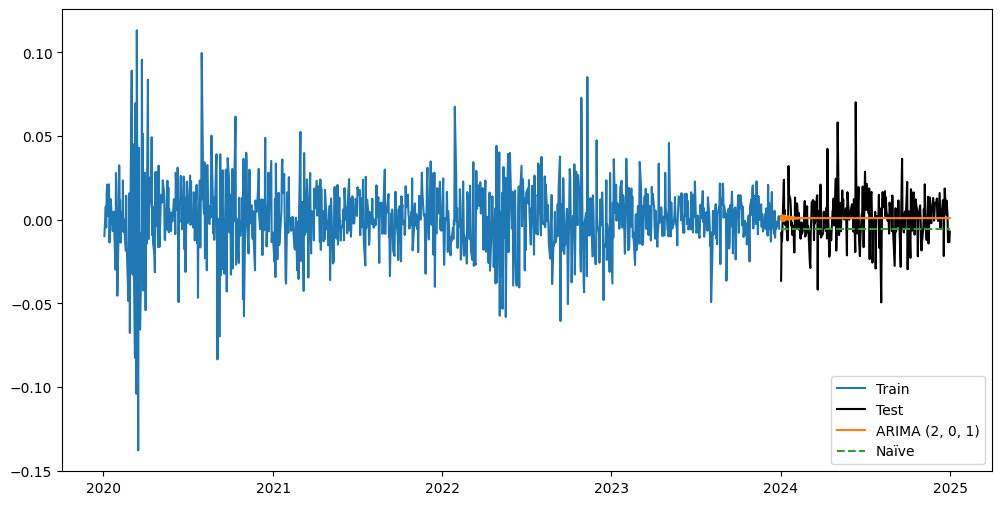

In [55]:
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test", color="black")
plt.plot(test.index, arima_pred, label=f"ARIMA {best_order}")
plt.plot(test.index, naive_pred, label="Naïve", linestyle="--")
plt.legend()
plt.show()

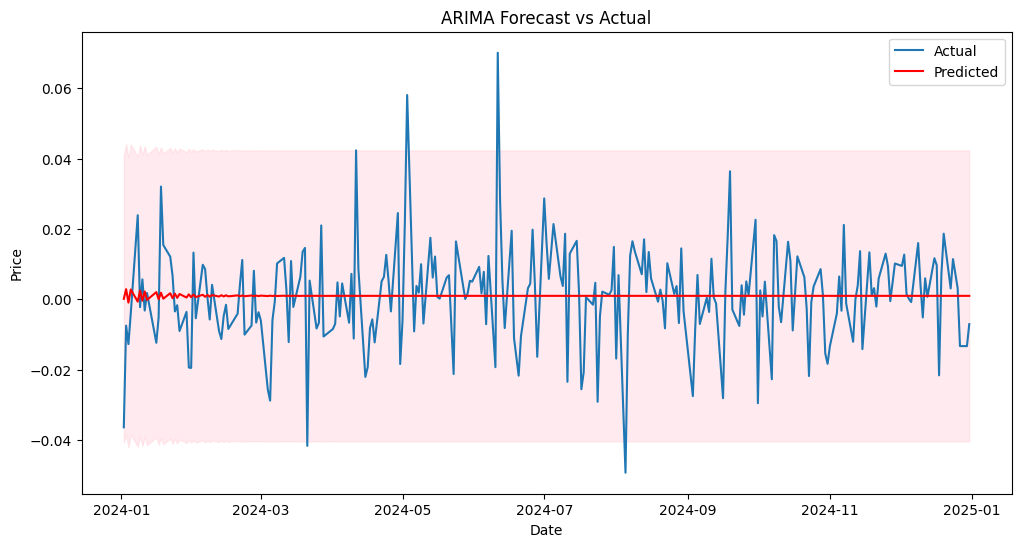

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

# Plot actual test data
plt.plot(test.index, test, label='Actual')

# Plot ARIMA predictions
plt.plot(test.index, arima_pred, label='Predicted', color='red')

# Plot confidence intervals as a shaded area
plt.fill_between(test.index,
                 conf_int.iloc[:, 0],  # lower bound
                 conf_int.iloc[:, 1],  # upper bound
                 color='pink', alpha=0.3)

plt.title('ARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
